# PRÁCTICA 1 - ANTONIO FERNÁNDEZ

Importamos las librerias necesarias

In [51]:
# Importamos librerías
import seaborn as sns  # Para gráficos
import numpy as np  # Operaciones numéricas
import cv2 # OpenCV
import os # Para manejo de archivos
from skimage.feature import local_binary_pattern  # Para cálculo de LBP

from sklearn.metrics import classification_report  # Para reporte de clasificación
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
from sklearn.model_selection import KFold # Para validación cruzada
from matplotlib import pyplot as plt # Para gráficos
from sklearn.svm import SVC # Para clasificador SVM
from PIL import Image # Para manejo de imágenes

Comenzamos transformando todas las imagenes a 128x128

In [52]:
def reescalar_imagenes(ruta_entrada, ruta_salida, clase):
    # Verificar si la carpeta de salida existe
    if not os.path.exists(ruta_salida):
        os.makedirs(ruta_salida)

    # Lista de archivos en la carpeta de entrada
    archivos = os.listdir(ruta_entrada)
    i = 0
    for archivo in archivos:
        i += 1
        ruta_entrada_completa = os.path.join(ruta_entrada, archivo)
        imagen = Image.open(ruta_entrada_completa)
        imagen_reescalada = imagen.resize((128, 128), Image.LANCZOS) #LANCZOS <- filtro para bajar calidad
        ruta_salida_completa = os.path.join(ruta_salida, f"{clase}_{str(i)}.jpeg")
        imagen_reescalada.save(ruta_salida_completa)
    print(f"¡Hecho! Se han transformado {i} imágenes.")

In [53]:
reescalar_imagenes('dataset/Train/Elephant', 'dataset2/Train/Elephant',"Elephant")
reescalar_imagenes('dataset/Test/Elephant', 'dataset2/Test/Elephant',"Elephant")
reescalar_imagenes('dataset/Valid/Elephant', 'dataset2/Valid/Elephant',"Elephant")

reescalar_imagenes('dataset/Train/Zebra', 'dataset2/Train/Zebra',"Zebra")
reescalar_imagenes('dataset/Test/Zebra', 'dataset2/Test/Zebra',"Zebra")
reescalar_imagenes('dataset/Valid/Zebra', 'dataset2/Valid/Zebra',"Zebra")

¡Hecho! Se han transformado 750 imágenes.
¡Hecho! Se han transformado 100 imágenes.
¡Hecho! Se han transformado 150 imágenes.
¡Hecho! Se han transformado 750 imágenes.
¡Hecho! Se han transformado 100 imágenes.
¡Hecho! Se han transformado 150 imágenes.


In [54]:
# Definimos las constantes globales
IMAGE_EXTENSION = ".png"  
# Parámetros para el descriptor HOG
win_size = (128,128)
cell_size = (8,8)                   
block_size = (16,16)
block_stride = (8,8)    
n_bins_orientacion = 9
# Característica del tamaño de LBP
blocksize = 64

In [55]:
# Modificación de la función calculate_descriptor
def calculate_descriptor(img, ALG, radius=1, n_points=8):
    """
    Calcula el descriptor de la imagen en función del algoritmo seleccionado.

    Parameters:
    img (numpy.array): Imagen en escala de grises.
    ALG (str): Algoritmo a usar: "HOG", "LBP", o "LBPU".
    radius (int): Radio de vecindad circular para LBP.
    n_points (int): Número de puntos vecinos para LBP.

    Returns:
    numpy.array: Descriptor calculado.
    """
    if ALG == "HOG":
        hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins_orientacion)
        return hog.compute(img).flatten()
    elif ALG == "LBP":
        # Calculamos el descriptor LBP
        descriptor = local_binary_pattern(img, P=n_points, R=radius, method='default')
        # Normalizamos el histograma
        descriptor = descriptor.ravel()/descriptor.max()
        return descriptor
    elif ALG == "LBPU":
        # Calculamos el descriptor LBPU
        descriptor = local_binary_pattern(img, P=n_points, R=radius, method='uniform')
        # Normalizamos el histograma
        descriptor = descriptor.ravel()/descriptor.max()
        return descriptor
    else:
        raise Exception("Algoritmo de descriptor no válido.")


# Función principal para cargar los datos de entrenamiento
def load_training_data(PATH_POSITIVE, PATH_NEGATIVE, PATH_THIRD="", ALG="HOG"):
    """
    Lee las imágenes de entrenamiento y calcula sus descriptores.

    Parameters:
    PATH_POSITIVE (str): Ruta a la carpeta con las imágenes positivas.
    PATH_NEGATIVE (str): Ruta a la carpeta con las imágenes negativas.
    PATH_THIRD (str): Ruta opcional para una tercera clase.
    ALG (str): Algoritmo de descriptor: "HOG", "LBP", o "LBPU".

    Returns:
    np.array: Descriptores de las imágenes.
    np.array: Etiquetas correspondientes.
    """
    training_data = []
    classes = []

    # Procesamos las imágenes positivas
    counter_positive_samples = 0
    for filename in os.listdir(PATH_POSITIVE):
        if filename.endswith(IMAGE_EXTENSION):
            filepath = os.path.join(PATH_POSITIVE, filename)
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error leyendo la imagen: {filepath}")
                continue
            try:
                descriptor = calculate_descriptor(img, ALG)
                training_data.append(descriptor)
                classes.append(1)
                counter_positive_samples += 1
            except Exception as e:
                print(f"Error procesando la imagen {filepath}: {e}")
    
    print(f"Leídas {counter_positive_samples} imágenes positivas.")

    # Procesamos las imágenes negativas
    counter_negative_samples = 0
    for filename in os.listdir(PATH_NEGATIVE):
        if filename.endswith(IMAGE_EXTENSION):
            filepath = os.path.join(PATH_NEGATIVE, filename)
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error leyendo la imagen: {filepath}")
                continue
            try:
                descriptor = calculate_descriptor(img, ALG)
                training_data.append(descriptor)
                classes.append(0)
                counter_negative_samples += 1
            except Exception as e:
                print(f"Error procesando la imagen {filepath}: {e}")
    
    print(f"Leídas {counter_negative_samples} imágenes negativas.")

    # Procesamos las imágenes de la tercera clase, si se proporciona
    if PATH_THIRD:
        counter_third_class_samples = 0
        for filename in os.listdir(PATH_THIRD):
            if filename.endswith(IMAGE_EXTENSION):
                filepath = os.path.join(PATH_THIRD, filename)
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error leyendo la imagen: {filepath}")
                    continue
                try:
                    descriptor = calculate_descriptor(img, ALG)
                    training_data.append(descriptor)
                    classes.append(2)
                    counter_third_class_samples += 1
                except Exception as e:
                    print(f"Error procesando la imagen {filepath}: {e}")
        
        print(f"Leídas {counter_third_class_samples} imágenes de la tercera clase.")

    return np.array(training_data), np.array(classes)

# Función para trazar la curva ROC
def curvaROC(predicted, labels, name):
    """
    Genera y guarda la curva ROC.

    Parameters:
    predicted (array-like): Valores predichos.
    labels (array-like): Etiquetas reales.
    name (str): Nombre del archivo de salida.
    """
    from sklearn.metrics import roc_curve, auc

    ruta = 'imagenes_p1/'
    fpr, tpr, thresholds = roc_curve(labels, predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="lower right", shadow=True, fontsize=14)
    plt.savefig(f"{ruta}{name}.png")

# Función para generar y guardar una matriz de confusión personalizada
def flex_confusion_matrix(cm, nombre_archivo, labels, tick_size=12, annot_size=14, cmap="Blues"):
    """
    Genera y guarda una matriz de confusión personalizada.

    Parameters:
    cm (numpy.array): Matriz de confusión.
    nombre_archivo (str): Nombre del archivo para guardar la imagen.
    labels (list): Etiquetas de las clases.
    tick_size (int): Tamaño de las marcas de los ejes.
    annot_size (int): Tamaño de las anotaciones.
    cmap (str): Mapa de colores.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=labels, yticklabels=labels, cbar=False,
                annot_kws={"size": annot_size})
    plt.xlabel("Predicción", fontsize=14)
    plt.ylabel("Real", fontsize=14)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.title("Matriz de Confusión", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"imagenes_p1/{nombre_archivo}.png", dpi=300)
    plt.show()

# Funciones para métricas de clasificación
def accuracy(cm):       return (cm[0, 0] + cm[1, 1]) / np.sum(cm)
def precision(cm):      return cm[1, 1] / (cm[1, 1] + cm[0, 1])
def recall(cm):         return cm[1, 1] / (cm[1, 1] + cm[1, 0])
def specificity(cm):    return cm[0, 0] / (cm[0, 0] + cm[0, 1])
def f1(cm):             return 2 * precision(cm) * recall(cm) / (precision(cm) + recall(cm))

In [56]:
# Rutas de los archivos
PATH_POSITIVE_TRAIN = "dataset2/Train/Elephant/"
PATH_NEGATIVE_TRAIN = "dataset2/Train/Zebra/"
PATH_POSITIVE_TEST = "dataset2/Test/Elephant/"
PATH_NEGATIVE_TEST = "dataset2/Test/Zebra/"
PATH_POSITIVE_VALID = "dataset2/Valid/Elephant/"
PATH_NEGATIVE_VALID = "dataset2/Valid/Zebra/"
IMAGE_EXTENSION = ".jpeg"

# HOG

In [57]:
# Cargamos los datos y los juntamos
training_data, training_classes = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, ALG="HOG")
test_data, test_classes = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, ALG="HOG")
valid_data, valid_classes = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, ALG="HOG")
# Los de validación los dejamos para testear al final
data = np.concatenate((training_data, test_data), axis=0)
classes = np.concatenate((training_classes, test_classes), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.


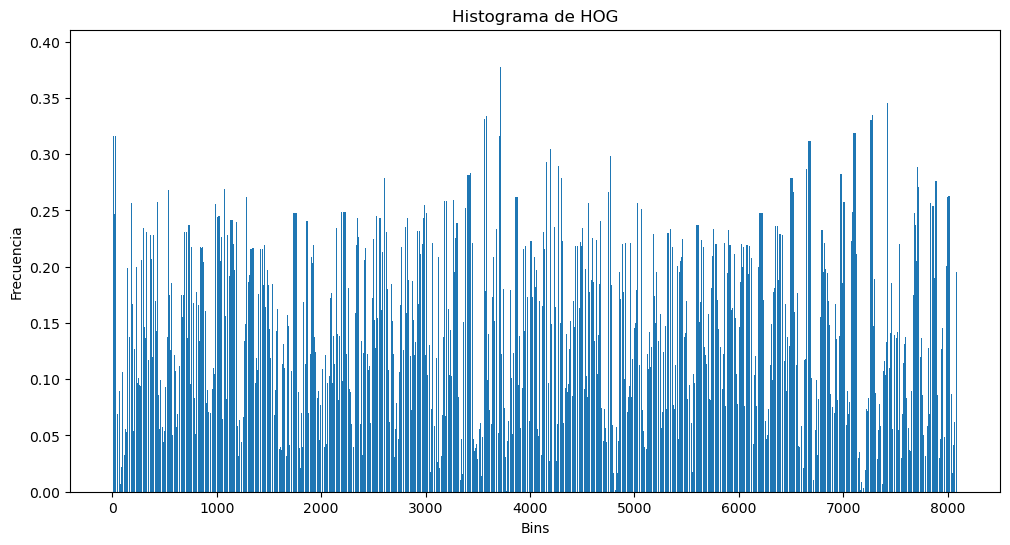

In [58]:
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(1,8101), height=training_data[0])
plt.title("Histograma de HOG")
plt.xlabel("Bins")
plt.ylabel("Frecuencia")
plt.savefig("imagenes_p1/hog_elephant_1.png")

La precisión es del 1.00 %
Reporte de estadísticas               precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



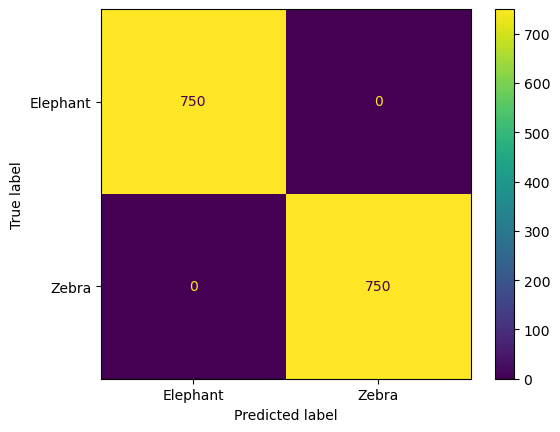

In [59]:
# Predicción del propio train
model = SVC(kernel="linear", random_state=0, cache_size=1000)
model.fit(training_data, training_classes)
pred = model.predict(training_data)
accuracy = np.mean(pred == training_classes)
print(f"La precisión es del {accuracy:.2f} %")
print("Reporte de estadísticas",classification_report(training_classes, pred))

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(training_classes, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Elephant", "Zebra"])
disp.plot()
plt.show()

La precisión es del 0.90 %
La precisión es del 0.90 %
Reporte de estadísticas:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       100
           1       0.91      0.88      0.89       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



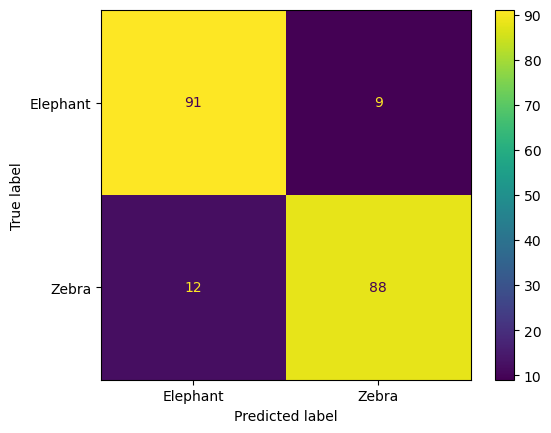

In [60]:
# Predicción del hold-out
pred = model.predict(test_data)
accuracy = np.mean(pred == test_classes)
print(f"La precisión es del {accuracy:.2f} %")
print(f"La precisión es del {accuracy:.2f} %")
print("Reporte de estadísticas:\n",classification_report(test_classes, pred))

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_classes, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Elephant", "Zebra"])
disp.plot()
plt.show()

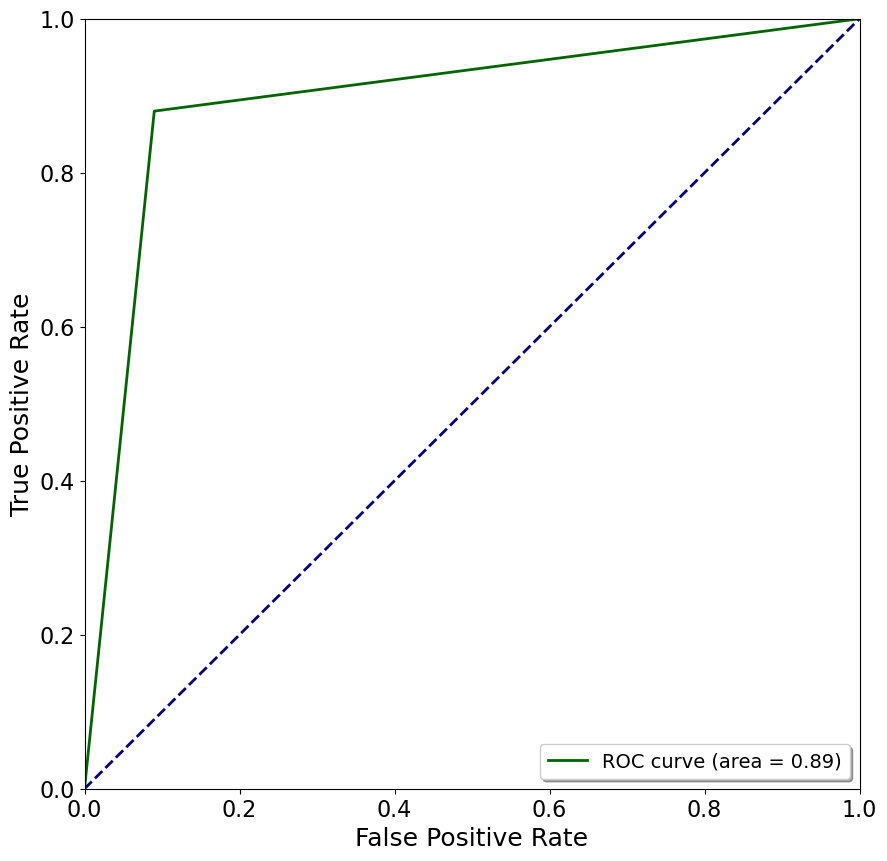

In [61]:
# Generar y mostrar la curva ROC
curvaROC(pred, test_classes, "hog_roc_holdout")

In [62]:
# metricas
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision(cm):.3f}")
print(f"Recall: {recall(cm):.3f}")
print(f"Specificity: {specificity(cm):.3f}")
print(f"F1: {f1(cm):.3f}")

Accuracy: 0.895
Precision: 0.907
Recall: 0.880
Specificity: 0.910
F1: 0.893


In [63]:
# Hacemos la cross-validation
folds = KFold(n_splits=10, shuffle=True, random_state=123)
folds.get_n_splits(data)
scores = [] # % accuracy
predictions = [] # para matriz de confusión
for i, (train_index, test_index) in enumerate(folds.split(data)):
    #if i==1: break #<- para testear
    print(f"Fold {i+1}:")
    data_train, data_test = data[train_index,], data[test_index,]
    classes_train, classes_test = classes[train_index], classes[test_index]
    model = SVC(kernel="linear", random_state=0, cache_size=1000)
    model.fit(data_train, classes_train)
    pred = model.predict(data_test)
    # accuracy
    accuracy = np.mean(pred == classes_test)
    print(f"La precisión es del {accuracy*100:.3f} %")
    predictions.append(pred)
    scores.append(accuracy)

Fold 1:
La precisión es del 85.294 %
Fold 2:
La precisión es del 87.059 %
Fold 3:
La precisión es del 82.941 %
Fold 4:
La precisión es del 84.706 %
Fold 5:
La precisión es del 84.706 %
Fold 6:
La precisión es del 87.059 %
Fold 7:
La precisión es del 85.294 %
Fold 8:
La precisión es del 85.882 %
Fold 9:
La precisión es del 87.059 %
Fold 10:
La precisión es del 87.059 %


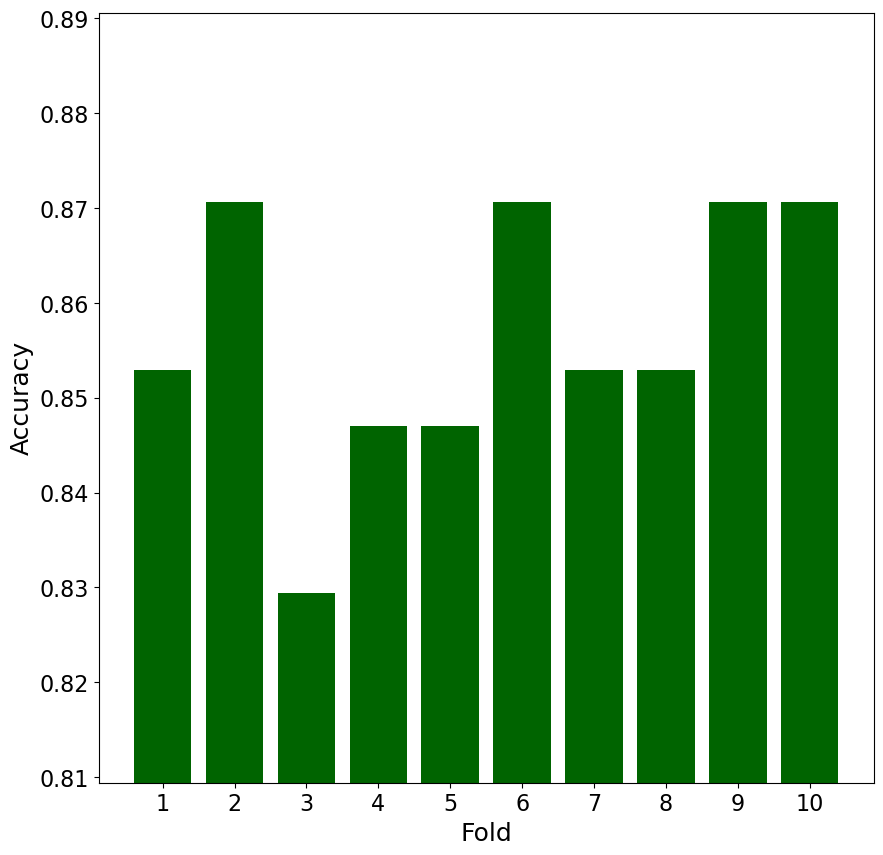

Gráfica guardada como imagenes_p1/hog_accuracy_cross_validation.png


In [64]:
# Datos de exactitud
accuracy = [0.85294, 0.87059, 0.82941, 0.84706, 0.84706, 0.87059, 0.85294, 0.85294, 0.87059, 0.87059]

# Configuración de la gráfica
plt.figure(figsize=(10, 10))
plt.bar(x=np.arange(1, 11), height=accuracy, color="darkgreen")
plt.xlabel("Fold", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(np.arange(1, 11), fontsize=16)
plt.yticks(fontsize=16)

# Ajustar rango del eje Y dinámicamente para asegurar que se ajusta a los datos
plt.ylim(min(accuracy) - 0.02, max(accuracy) + 0.02)

# Guardar la gráfica
output_path = "imagenes_p1/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

image_path = f"{output_path}hog_accuracy_cross_validation.png"
plt.savefig(image_path, dpi=300)

# Mostrar la gráfica
plt.show()

print(f"Gráfica guardada como {image_path}")

In [65]:
# valor medio del acc en cv
print(f"La precisión media es del {100*np.mean([0.85294, 0.87059, 0.82941, 0.84706, 0.84706, 0.87059, 0.85294, 0.85294, 0.87059, 0.87059]):.3f} %")

La precisión media es del 85.647 %


Realizamos un ajuste de hiperparámetros utilizando GridSearchCV, con el objetivo de optimizar diferentes combinaciones de kernels y sus hiperparámetros correspondientes para un modelo SVM.

In [66]:
grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1/8100, 0.1, 0.5]}, {'kernel':['sigmoid']}]
autoGrid = GridSearchCV(SVC(), param_grid=grid, cv=5, scoring='accuracy') #cambiar cv a 5 o 10 cuando lo ejecute al final
autoGrid.fit(data, classes)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'kernel': ['linear']},
                         {'gamma': [0.0001234567901234568, 0.1, 0.5],
                          'kernel': ['rbf']},
                         {'kernel': ['sigmoid']}],
             scoring='accuracy')

In [67]:
print(f"Los mejores parámetros son:, {autoGrid.best_params_}")
autoGrid.cv_results_

Los mejores parámetros son:, {'kernel': 'linear'}


{'mean_fit_time': array([2.36361933, 3.67864814, 3.57858758, 3.87969985, 3.57982664]),
 'std_fit_time': array([0.49016707, 0.11527222, 0.04375374, 0.25159146, 0.31600637]),
 'mean_score_time': array([0.40411997, 2.42868466, 2.37522769, 2.45857635, 0.83308582]),
 'std_score_time': array([0.03665551, 0.05789585, 0.00861146, 0.07888419, 0.02164583]),
 'param_kernel': masked_array(data=['linear', 'rbf', 'rbf', 'rbf', 'sigmoid'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[--, 0.0001234567901234568, 0.1, 0.5, --],
              mask=[ True, False, False, False,  True],
        fill_value=1e+20),
 'params': [{'kernel': 'linear'},
  {'gamma': 0.0001234567901234568, 'kernel': 'rbf'},
  {'gamma': 0.1, 'kernel': 'rbf'},
  {'gamma': 0.5, 'kernel': 'rbf'},
  {'kernel': 'sigmoid'}],
 'split0_test_score': array([0.83235294, 0.76470588, 0.59705882, 0.52058824, 0.47941176]),
 'split1_test_score': array([

Ahora uttilizmos GridSearchCV para realizar una búsqueda exhaustiva sobre un conjunto especificado de valores de hiperparámetros para un modelo. En este caso, se ajusta el hiperparámetro C del modelo SVM.

In [68]:
autoGridC = GridSearchCV(SVC(kernel="linear"), param_grid={"C":np.logspace(-5, 0, 6)}, cv=5, scoring='accuracy') #cambiar cv a 5 o 10 cuando lo ejecute al final
autoGridC.fit(data, classes)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             scoring='accuracy')

In [69]:
print(f"Los mejores parámetros son:, {autoGridC.best_params_}")
autoGridC.cv_results_

Los mejores parámetros son:, {'C': 0.01}


{'mean_fit_time': array([3.79592943, 3.72388988, 3.84413815, 2.64822717, 2.18409677,
        2.56082754]),
 'std_fit_time': array([0.15415091, 0.20869545, 0.30335727, 0.20610128, 0.20546674,
        0.77636203]),
 'mean_score_time': array([0.97228856, 0.91557465, 0.92309508, 0.58573084, 0.39480357,
        0.41640229]),
 'std_score_time': array([0.08031372, 0.04348708, 0.07576045, 0.09118055, 0.03977525,
        0.07020246]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0}],
 'split0_test_score': array([0.76764706, 0.76764706, 0.78529412, 0.82647059, 0.82941176,
        0.83235294]),
 'split1_test_score': array([0.84117647, 0.84117647, 0.85882353, 0.89705882, 0.87647059,
        0.87352941]),
 'split2_test_score': array([0.81764706, 0.81764706, 0.85      , 0.89411765, 0.864705

Por último, vamos a entrenar un SVM con las mejores características usando train+test y vamos a evaluar validation.

In [70]:
bestSVM = SVC(kernel="linear", C=0.01)
bestSVM.fit(data, classes)

SVC(C=0.01, kernel='linear')

In [71]:
y_val = bestSVM.predict(valid_data)
val_score = np.mean(y_val == valid_classes)
print(f"La precisión es del {100*val_score:.3f} %")
cm_val = confusion_matrix(valid_classes, y_val)

La precisión es del 86.000 %


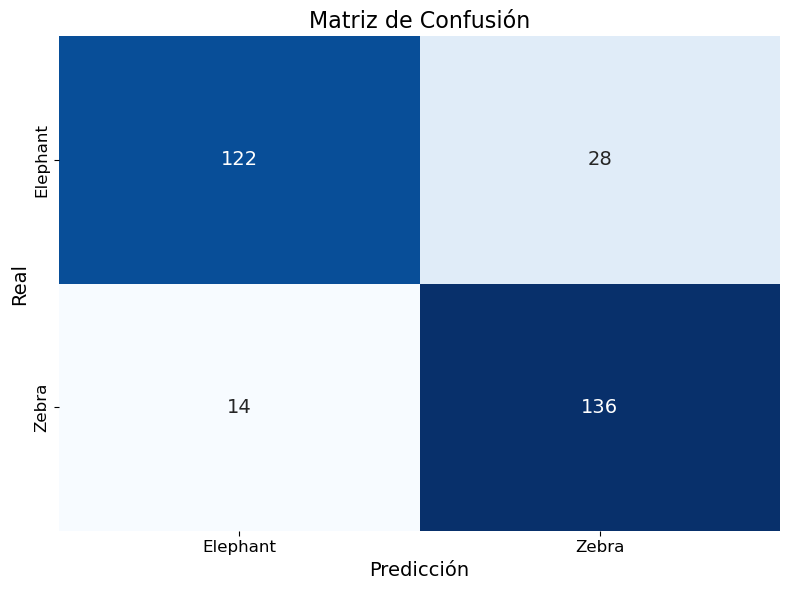

In [72]:
flex_confusion_matrix(cm_val, "hog_val_cm", labels=["Elephant", "Zebra"])

In [73]:
# metricas
print(f"Accuracy: {val_score:.3f}")
print(f"Precision: {precision(cm_val):.3f}")
print(f"Recall: {recall(cm_val):.3f}")
print(f"Specificity: {specificity(cm_val):.3f}")
print(f"F1: {f1(cm_val):.3f}")

Accuracy: 0.860
Precision: 0.829
Recall: 0.907
Specificity: 0.813
F1: 0.866


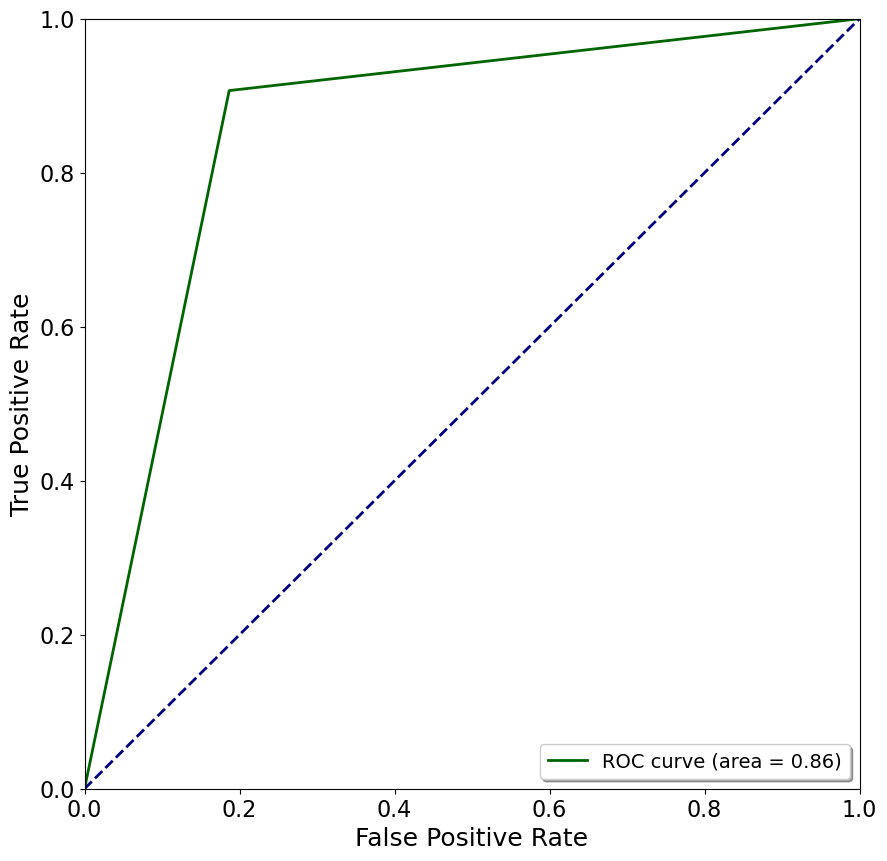

In [74]:
curvaROC(y_val, valid_classes, "hog_val_roc")

Calculamos una imagen de cada clase para ver como funciona

In [75]:
# imagenes de prueba
valid_data_pos = valid_data[[3]]
valid_data_neg = valid_data[[150]]  # Changed index to a valid one
print("Predicción de la imagen positiva: ", bestSVM.predict(valid_data_pos),". Clase real de la imagen:", valid_classes[3])
print("Predicción de la imagen negativa: ", bestSVM.predict(valid_data_neg),". Clase real de la imagen:", valid_classes[150])

Predicción de la imagen positiva:  [1] . Clase real de la imagen: 1
Predicción de la imagen negativa:  [0] . Clase real de la imagen: 0


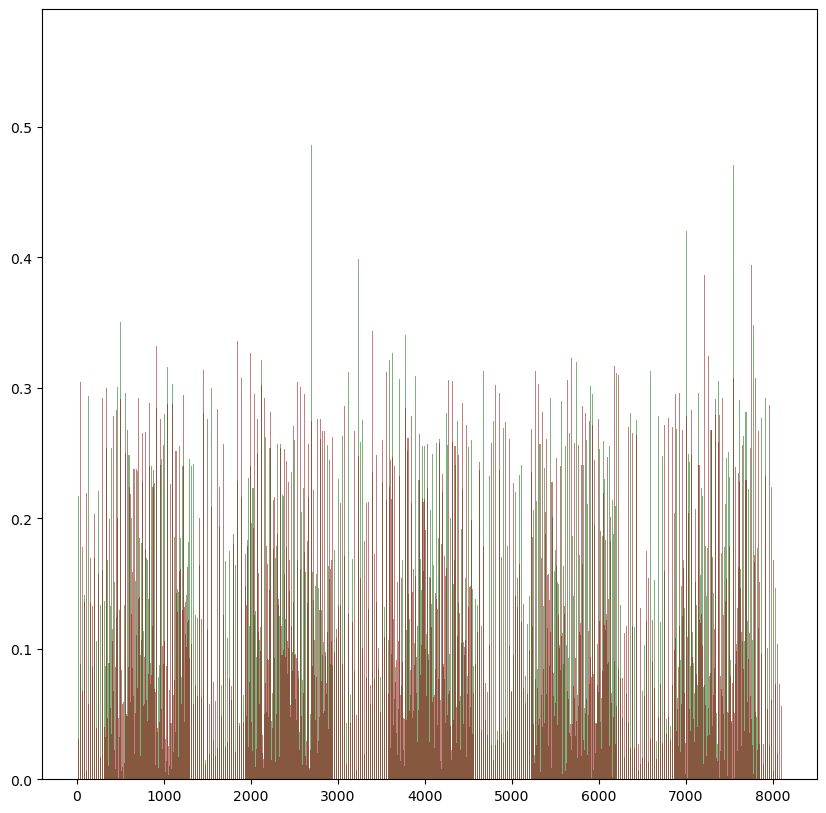

In [76]:
# representamos el histograma de las dos imágenes en la misma grafica
plt.figure(figsize=(10,10))
plt.bar(x=np.arange(1,8101), height=valid_data_pos[0], color="darkgreen", alpha=0.5, label="Elephant")
plt.bar(x=np.arange(1,8101), height=valid_data_neg[0], color="darkred", alpha=0.5, label="Zebra")
plt.savefig("imagenes_p1/hog_hist_val.png")

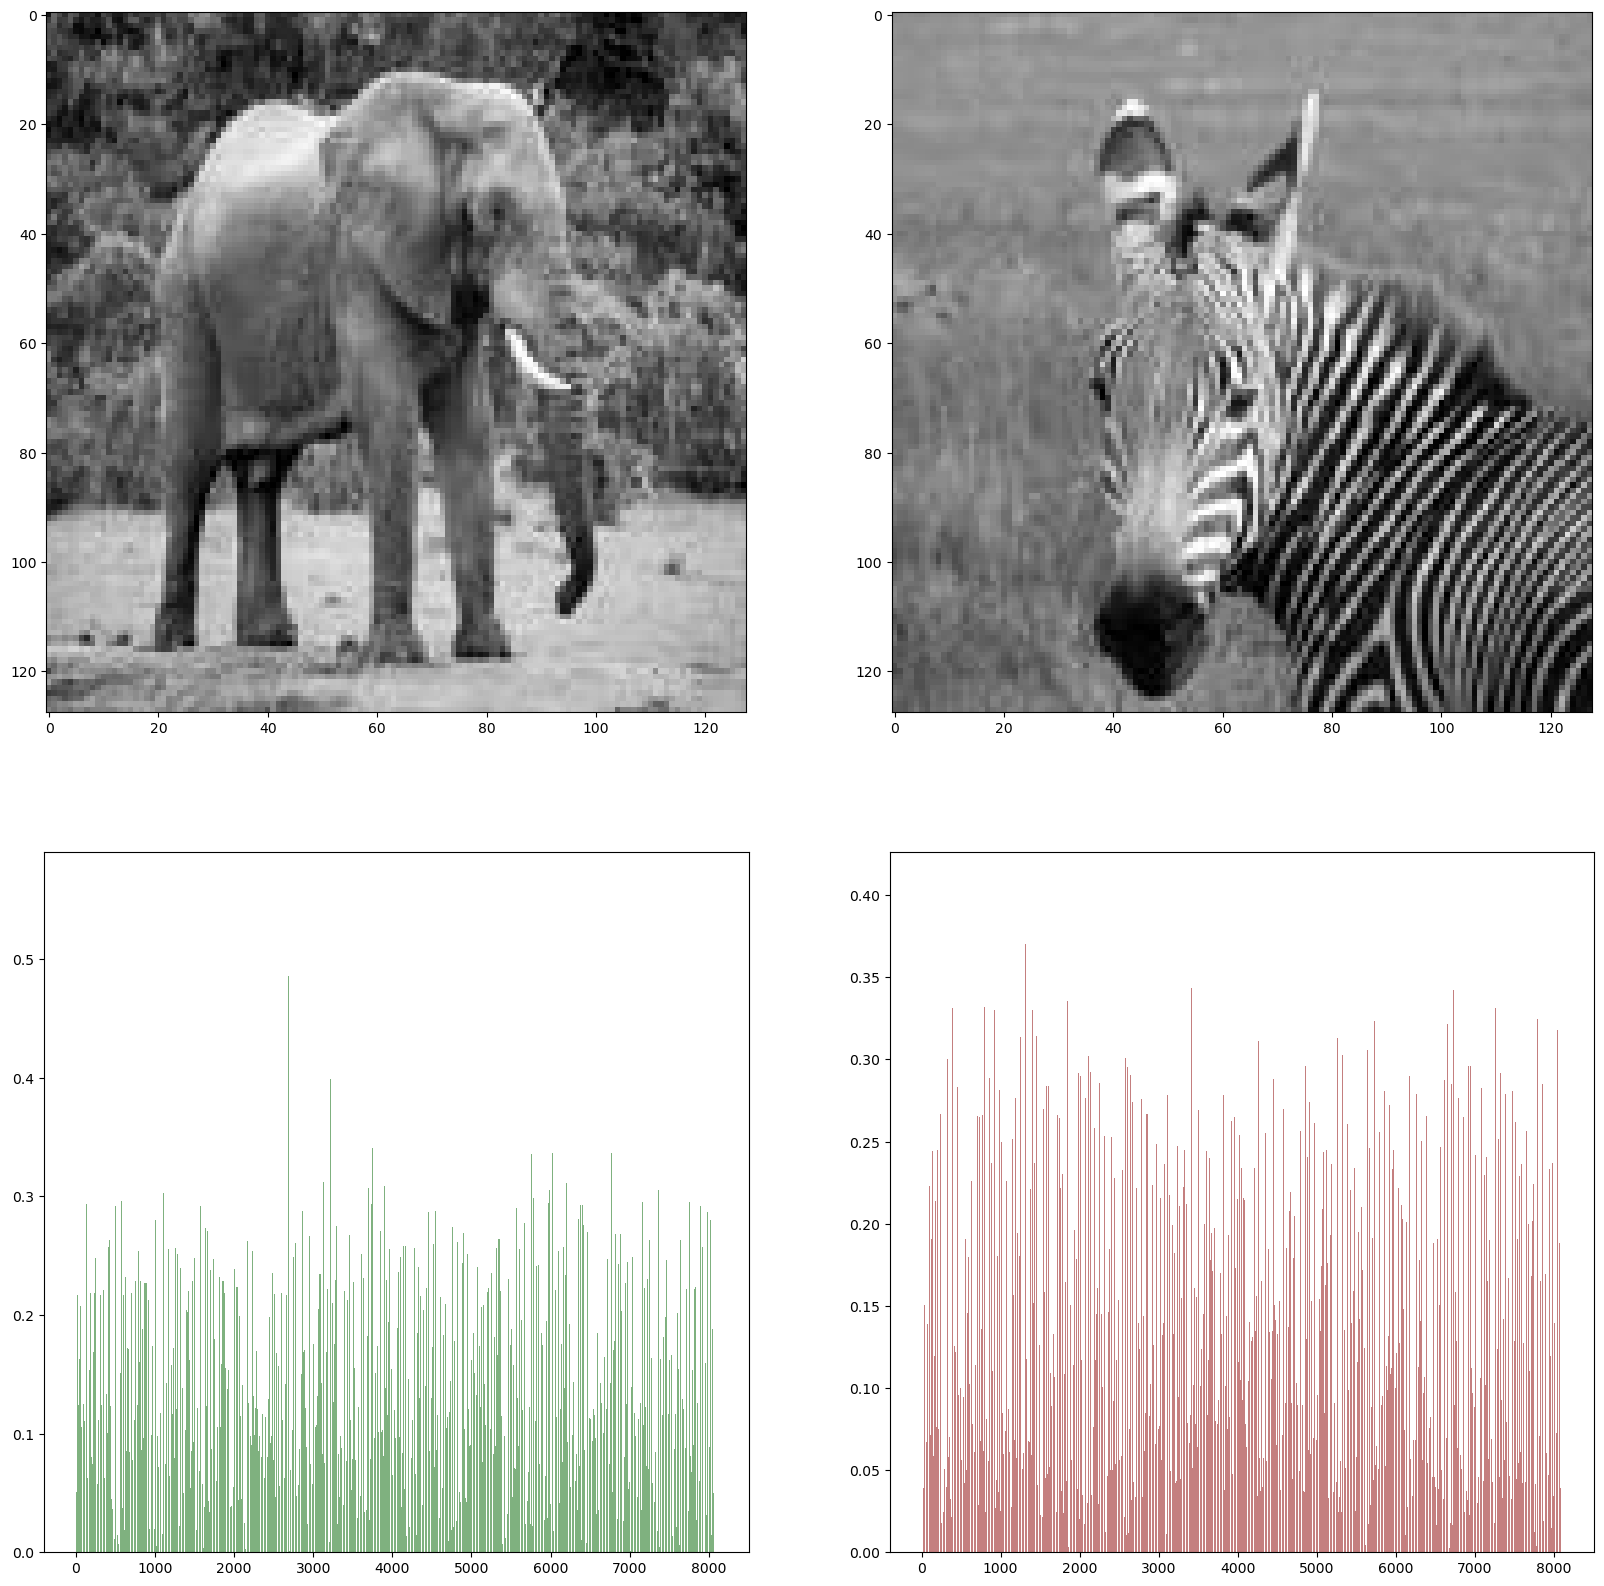

In [77]:
# representamos el histograma de las dos imágenes en la misma grafica
plt.figure(figsize=(20,20))
ruta='imagenes_p1'
img_prueba_pos = 'dataset2/Valid/Elephant/Elephant_5.jpeg'
img_prueba_neg = 'dataset2/Valid/Zebra/Zebra_5.jpeg'
image_pos = cv2.imread(img_prueba_pos, cv2.IMREAD_GRAYSCALE)
image_neg = cv2.imread(img_prueba_neg, cv2.IMREAD_GRAYSCALE)

plt.subplot(2,2,1)
plt.imshow(image_pos, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(image_neg, cmap='gray')
plt.subplot(2,2,3)
plt.bar(x=np.arange(1,8101), height=valid_data_pos[0], color="darkgreen", alpha=0.5, label="Elephant")
plt.subplot(2,2,4)
plt.bar(x=np.arange(1,8101), height=valid_data_neg[0], color="darkred", alpha=0.5, label="Zebra")
plt.savefig("imagenes_p1/hog_hist_val.png")

# LBP

Ahora mismo vamos a probar con usar la librería skimage (scikit-learn pero para imágenes) que ya tiene implementado el método LBP (Local Binary Patterns).

In [78]:
# Cargamos los datos en LBP y los juntamos
training_data, training_classes = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, ALG="LBP")
test_data, test_classes = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, ALG="LBP")
valid_data, valid_classes = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, ALG="LBP")
data = np.concatenate((training_data, test_data), axis=0)
classes = np.concatenate((training_classes, test_classes), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.


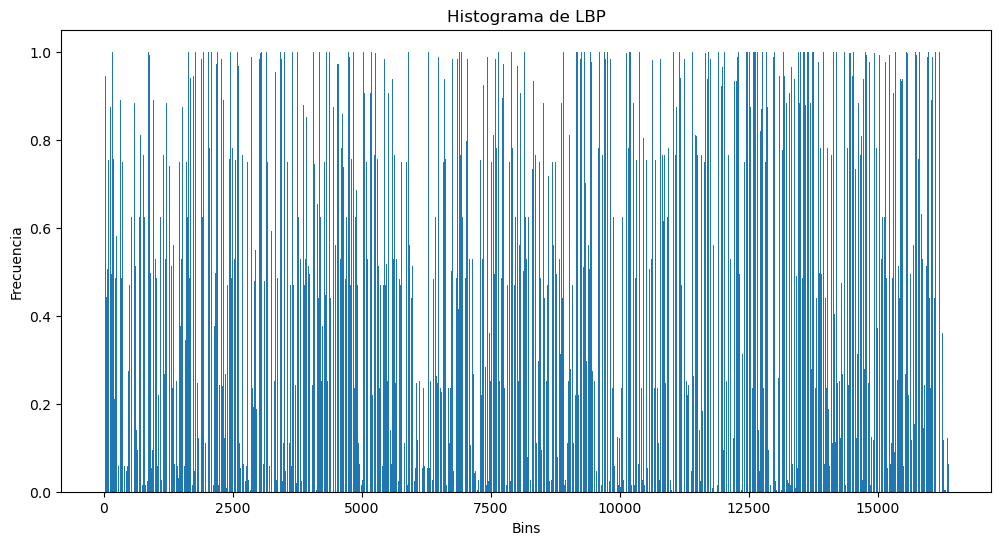

In [79]:
# Visualizar el histograma de 16384 bins
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(16384), height=training_data[0])
plt.title("Histograma de LBP")
plt.xlabel("Bins")
plt.ylabel("Frecuencia")
plt.savefig("imagenes_p1/lbp_elephant_1.png")

In [80]:
# Hacemos la cross-validation
folds = KFold(n_splits=10, shuffle=True, random_state=123)
folds.get_n_splits(data)
scores = [] # % accuracy
predictions = [] # para matriz de confusión
for i, (train_index, test_index) in enumerate(folds.split(data)):
    #if i==1: break #<- para testear
    print(f"Fold {i+1}:")
    data_train, data_test = data[train_index,], data[test_index,]
    classes_train, classes_test = classes[train_index], classes[test_index]
    model = SVC(kernel="linear", random_state=0, cache_size=1000)
    model.fit(data_train, classes_train)
    pred = model.predict(data_test)
    # accuracy
    accuracy = np.mean(pred == classes_test)
    print(f"La precisión es del {100*accuracy:.3f} %")
    predictions.append(pred)
    scores.append(accuracy)

Fold 1:
La precisión es del 60.000 %
Fold 2:
La precisión es del 55.882 %
Fold 3:
La precisión es del 60.588 %
Fold 4:
La precisión es del 58.235 %
Fold 5:
La precisión es del 60.588 %
Fold 6:
La precisión es del 59.412 %
Fold 7:
La precisión es del 59.412 %
Fold 8:
La precisión es del 60.000 %
Fold 9:
La precisión es del 65.882 %
Fold 10:
La precisión es del 61.765 %


In [81]:
lbp_cv_scores = [0.60000, 0.55882, 0.60588, 0.58235, 0.60588, 0.59412, 0.59412, 0.60000, 0.65882, 0.61765]
print(f"La precisión media es del {100*np.mean(lbp_cv_scores):.3f} %")

La precisión media es del 60.176 %


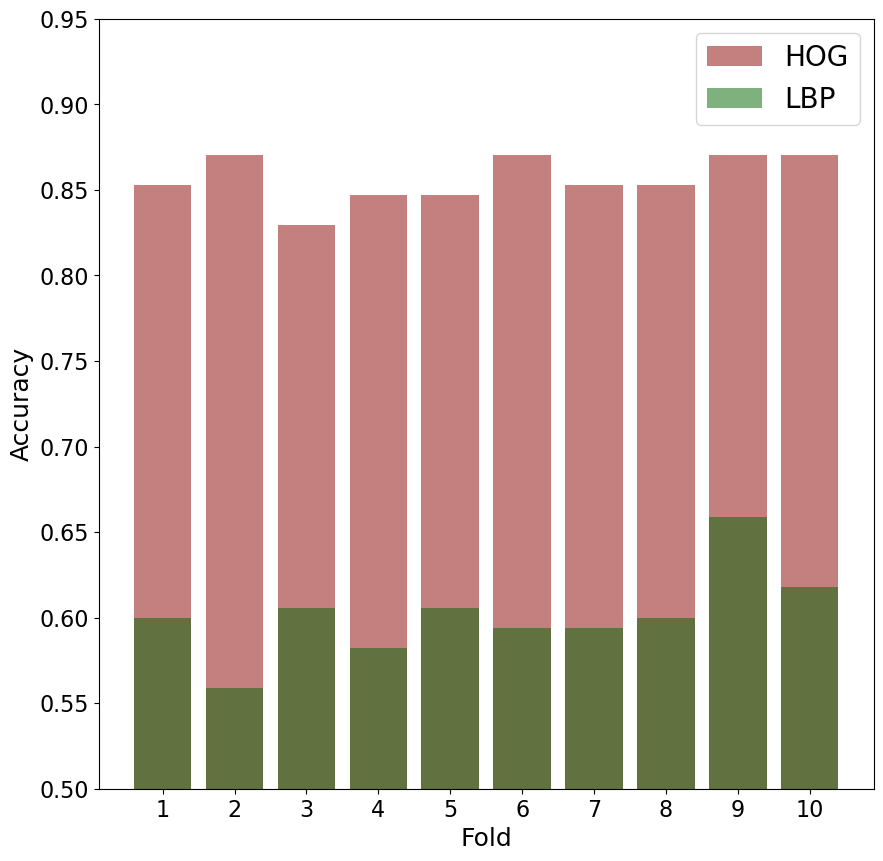

In [82]:
hog_cv_scores = [0.85294, 0.87059, 0.82941, 0.84706, 0.84706, 0.87059, 0.85294, 0.85294, 0.87059, 0.87059]
plt.figure(figsize=(10,10))
plt.bar(x=np.arange(1,11), height=hog_cv_scores, color="darkred", alpha=0.5)
plt.bar(x=np.arange(1,11), height=lbp_cv_scores, color="darkgreen", alpha = 0.5)
plt.xlabel("Fold", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(np.arange(1,11), fontsize=16)
plt.yticks(fontsize=16)
plt.legend(["HOG", "LBP"], fontsize=20)
plt.ylim(0.5, 0.95)
plt.savefig("imagenes_p1/lbp_accuracy_cross_validation.png")

In [83]:
# GRID SEARCH
grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': ['scale', 0.1, 0.5]}, {'kernel':['sigmoid']}]
autoGridLBP = GridSearchCV(SVC(), param_grid=grid, cv=5, scoring='accuracy') #cambiar cv a 5 o 10 cuando lo ejecute al final
autoGridLBP.fit(data, classes)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'kernel': ['linear']},
                         {'gamma': ['scale', 0.1, 0.5], 'kernel': ['rbf']},
                         {'kernel': ['sigmoid']}],
             scoring='accuracy')

In [84]:
print("Mejores parámetros:", autoGridLBP.best_params_)
print("Mejor estimador:", autoGridLBP.best_estimator_)
autoGridLBP.cv_results_ 

Mejores parámetros: {'gamma': 'scale', 'kernel': 'rbf'}
Mejor estimador: SVC()


{'mean_fit_time': array([7.35568318, 7.31104078, 7.16677933, 7.04598603, 7.20693879]),
 'std_fit_time': array([0.20889555, 0.19258444, 0.00626259, 0.16625891, 0.11455428]),
 'mean_score_time': array([1.73564768, 5.17903414, 5.19555292, 5.20339866, 1.76059089]),
 'std_score_time': array([0.07365356, 0.05904667, 0.023095  , 0.03046734, 0.04224587]),
 'param_kernel': masked_array(data=['linear', 'rbf', 'rbf', 'rbf', 'sigmoid'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[--, 'scale', 0.1, 0.5, --],
              mask=[ True, False, False, False,  True],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'linear'},
  {'gamma': 'scale', 'kernel': 'rbf'},
  {'gamma': 0.1, 'kernel': 'rbf'},
  {'gamma': 0.5, 'kernel': 'rbf'},
  {'kernel': 'sigmoid'}],
 'split0_test_score': array([0.59705882, 0.72352941, 0.5       , 0.5       , 0.52058824]),
 'split1_test_score': array([0.6

In [85]:
# Parámetros optimizados
param_grid = [
    {'kernel': ['rbf'], 
     'C': [ 1, 10, 25],           # Regularización
     'gamma': ['scale', 0.5, 1]},  # Ajuste de gamma
    {'kernel': ['linear'], 
     'C': [ 1, 10, 25]},          # Solo optimizamos C en kernel linear
]

# Configurar el GridSearchCV
autoGrid = GridSearchCV(SVC(), param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Ajustar el modelo
autoGrid.fit(data, classes)

# Resultados
print("Mejores parámetros:", autoGrid.best_params_)
print("Mejor estimador:", autoGrid.best_estimator_)
print("Precisión promedio en validación cruzada:", autoGrid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor estimador: SVC(C=1)
Precisión promedio en validación cruzada: 0.6847058823529412


In [86]:
# Modelo con los mejores parámetros encontrados
bestSVMlbp = SVC(C=1, gamma='scale', kernel='rbf')

# Entrenamos el modelo con todos los datos
bestSVMlbp.fit(data, classes)

SVC(C=1)

In [87]:
y_val = bestSVMlbp.predict(valid_data)
val_score = np.mean(y_val == valid_classes)
print(f"La precisión es del {100*val_score:.3f} %")
cm_val = confusion_matrix(valid_classes, y_val)

La precisión es del 63.000 %


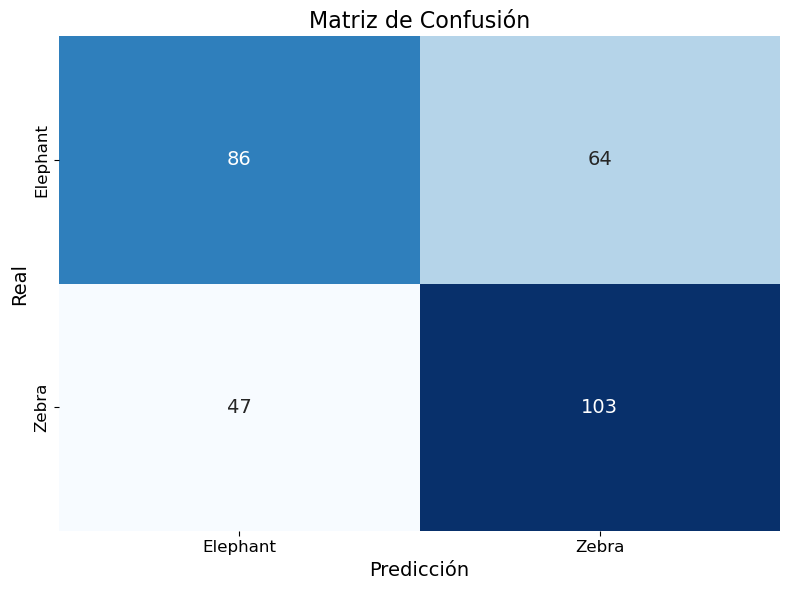

In [88]:
flex_confusion_matrix(cm=cm_val, nombre_archivo="lbp_val_cm", labels=["Elephant", "Zebra"])

In [89]:
# metricas
print(f"Accuracy: {val_score:.3f}")
print(f"Precision: {precision(cm_val):.3f}")
print(f"Recall: {recall(cm_val):.3f}")
print(f"Specificity: {specificity(cm_val):.3f}")
print(f"F1: {f1(cm_val):.3f}")

Accuracy: 0.630
Precision: 0.617
Recall: 0.687
Specificity: 0.573
F1: 0.650


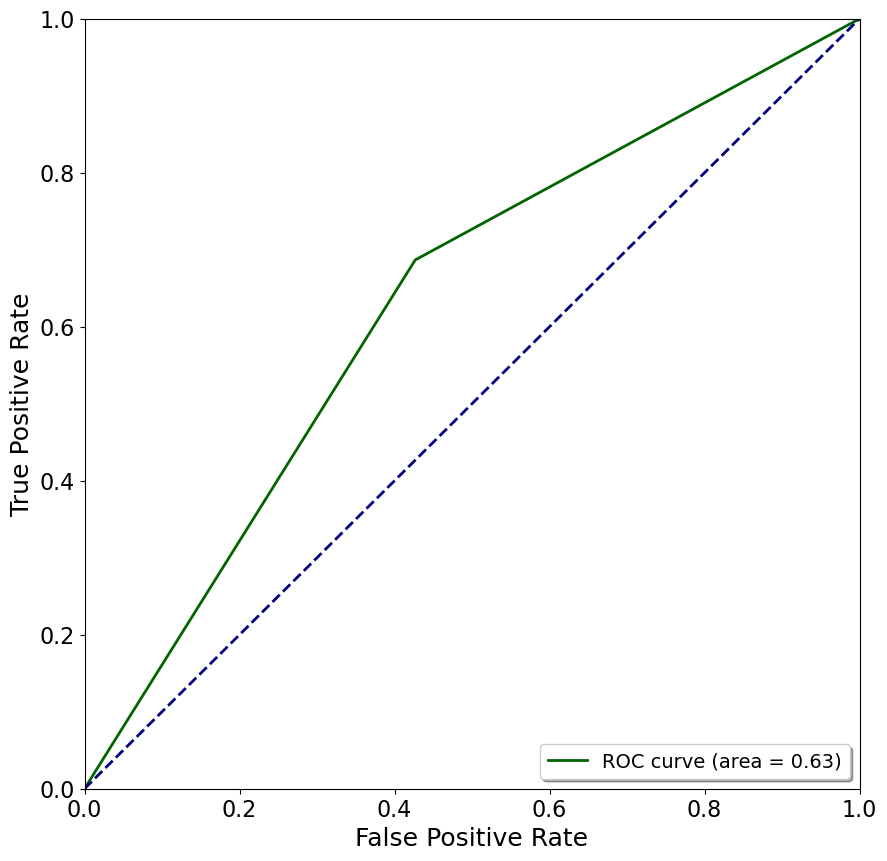

In [90]:
curvaROC(y_val, valid_classes, "lbp_val_roc")

Calculamos una imagen de cada clase para ver como funciona

In [91]:
# Imagenes de prueba
valid_data_pos = valid_data[[3]]
valid_data_neg = valid_data[[150]]
print("Predicción de la imagen positiva: ", bestSVMlbp.predict(valid_data_pos),". Clase real de la imagen:", valid_classes[3])
print("Predicción de la imagen negativa: ", bestSVMlbp.predict(valid_data_neg),". Clase real de la imagen:", valid_classes[150])


# Cargamos el descriptor HOG para las imágenes
valid_data_hog, valid_classes_hog = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, ALG="HOG")
valid_data_HOG_pos = valid_data_hog[[3]]
valid_data_HOG_neg = valid_data_hog[[150]]

Predicción de la imagen positiva:  [1] . Clase real de la imagen: 1
Predicción de la imagen negativa:  [1] . Clase real de la imagen: 0
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.


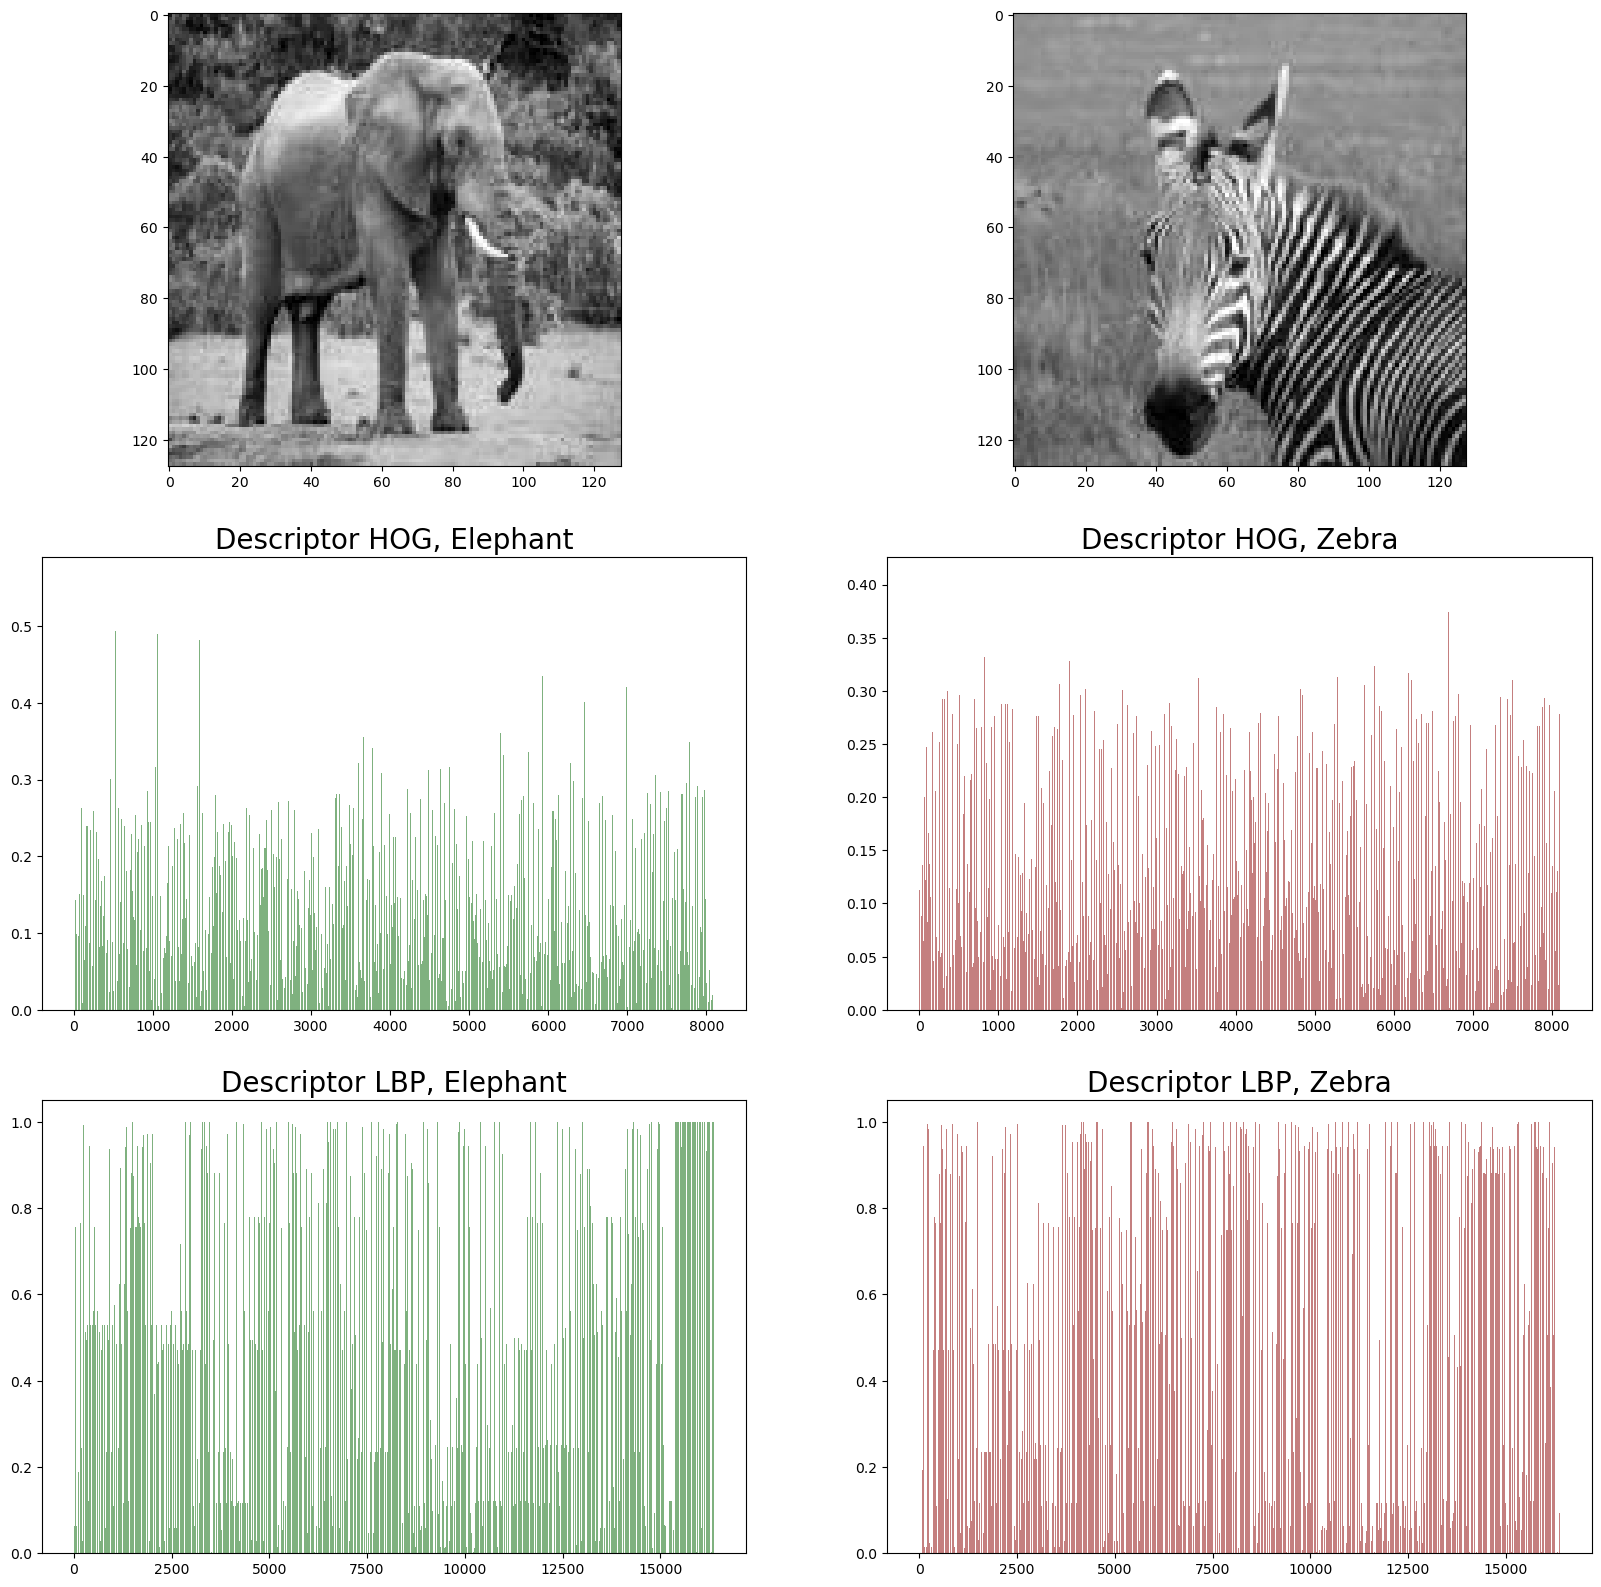

In [92]:
# representamos el histograma de las dos imágenes en la misma grafica
plt.figure(figsize=(20,20))
ruta='imagenes_p1'
img_prueba_pos = 'dataset2/Valid/Elephant/Elephant_5.jpeg'
img_prueba_neg = 'dataset2/Valid/Zebra/Zebra_5.jpeg'
image_pos = cv2.imread(img_prueba_pos, cv2.IMREAD_GRAYSCALE)
image_neg = cv2.imread(img_prueba_neg, cv2.IMREAD_GRAYSCALE)

plt.subplot(3,2,1)
plt.imshow(image_pos, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(image_neg, cmap='gray')
plt.subplot(3,2,3)
plt.bar(x=np.arange(1,8101), height=valid_data_HOG_pos[0], color="darkgreen", alpha=0.5, label="Elephant")
plt.title("Descriptor HOG, Elephant", fontsize=20)
plt.subplot(3,2,4)
plt.bar(x=np.arange(1,8101), height=valid_data_HOG_neg[0], color="darkred", alpha=0.5, label="Zebra")
plt.title("Descriptor HOG, Zebra", fontsize=20)
plt.subplot(3,2,5)
plt.bar(x=np.arange(16384), height=valid_data_pos[0], color="darkgreen", alpha=0.5, label="Elephant")
plt.title("Descriptor LBP, Elephant", fontsize=20)
plt.subplot(3,2,6)
plt.bar(x=np.arange(16384), height=valid_data_neg[0], color="darkred", alpha=0.5, label="Zebra")
plt.title("Descriptor LBP, Zebra", fontsize=20)
plt.savefig("imagenes_p1/hog_lbp_hist_val.png")

# LBPU

Consiste en un mapeo de lbp básico a nuevos valores que componen las transiciones de 0 a 1

In [93]:
# Cargamos los datos en LBPU y los juntamos
training_data, training_classes = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, ALG="LBPU")
test_data, test_classes = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, ALG="LBPU")
valid_data, valid_classes = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, ALG="LBPU")
data = np.concatenate((training_data, test_data), axis=0)
classes = np.concatenate((training_classes, test_classes), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.


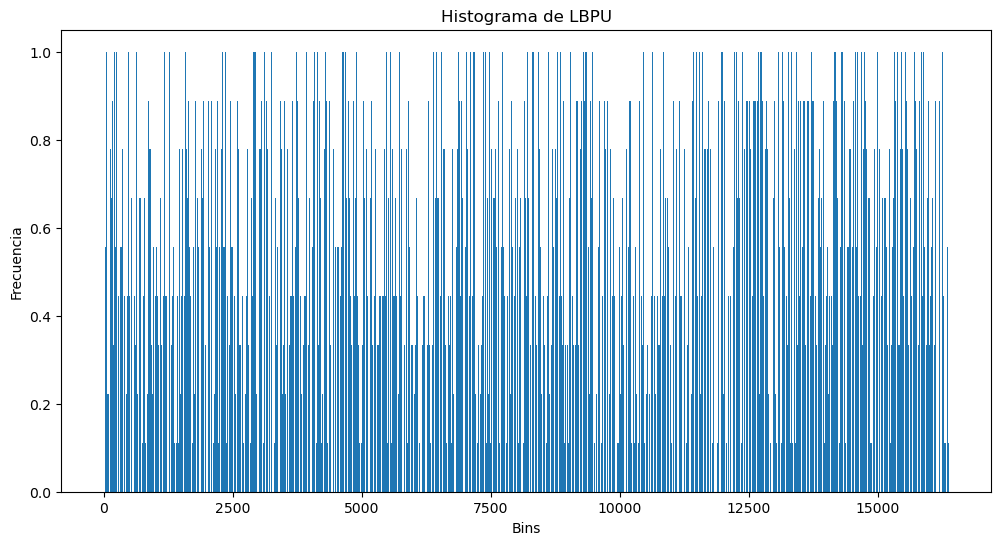

In [94]:
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(16384), height=training_data[0])
plt.title("Histograma de LBPU")
plt.xlabel("Bins")
plt.ylabel("Frecuencia")
plt.savefig("imagenes_p1/lbpu_elephant_1.png")

In [95]:
# Hacemos la cross-validation
folds = KFold(n_splits=10, shuffle=True, random_state=123)
folds.get_n_splits(data)
scores = [] # % accuracy
predictions = [] # para matriz de confusión
for i, (train_index, test_index) in enumerate(folds.split(data)):
    #if i==1: break #<- para testear
    print(f"Fold {i+1}:")
    data_train, data_test = data[train_index,], data[test_index,]
    classes_train, classes_test = classes[train_index], classes[test_index]
    model = SVC(kernel="linear", random_state=0, cache_size=1000)
    model.fit(data_train, classes_train)
    pred = model.predict(data_test)
    # accuracy
    accuracy = np.mean(pred == classes_test)
    print(f"La precisión es del {100*accuracy:.3f} %")
    predictions.append(pred)
    scores.append(accuracy)

Fold 1:
La precisión es del 67.647 %
Fold 2:
La precisión es del 62.941 %
Fold 3:
La precisión es del 58.824 %
Fold 4:
La precisión es del 65.882 %
Fold 5:
La precisión es del 69.412 %
Fold 6:
La precisión es del 70.000 %
Fold 7:
La precisión es del 64.706 %
Fold 8:
La precisión es del 65.294 %
Fold 9:
La precisión es del 63.529 %
Fold 10:
La precisión es del 62.941 %


In [96]:
lbpu_cv_scores = [0.67647, 0.62941, 0.58824, 0.65882, 0.69412, 0.70000, 0.64706, 0.65294, 0.63529, 0.62941]
np.mean(lbpu_cv_scores)

0.651176

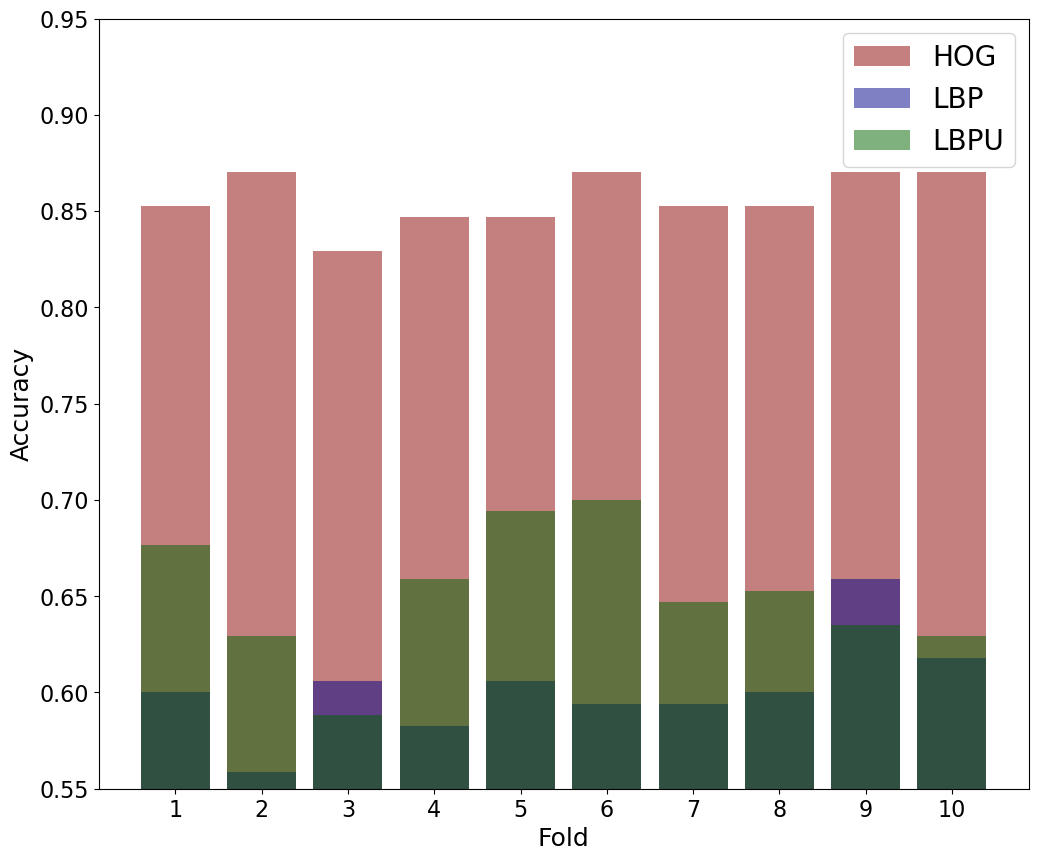

In [97]:
lbp_cv_scores = [0.60000, 0.55882, 0.60588, 0.58235, 0.60588, 0.59412, 0.59412, 0.60000, 0.65882, 0.61765]
hog_cv_scores = [0.85294, 0.87059, 0.82941, 0.84706, 0.84706, 0.87059, 0.85294, 0.85294, 0.87059, 0.87059]
plt.figure(figsize=(12,10))
plt.bar(x=np.arange(1,11), height=hog_cv_scores, color="darkred", alpha=0.5)
plt.bar(x=np.arange(1,11), height=lbp_cv_scores, color="darkblue", alpha = 0.5)
plt.bar(x=np.arange(1,11), height=lbpu_cv_scores, color="darkgreen", alpha = 0.5)
plt.xlabel("Fold", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(np.arange(1,11), fontsize=16)
plt.yticks(fontsize=16)
plt.legend(["HOG", "LBP","LBPU"], fontsize=20)
plt.ylim(0.55, 0.95)
plt.savefig("imagenes_p1/lbpu_accuracy_cross_validation.png")

In [98]:
# GRID SEARCH
grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': ['scale', 0.1, 0.5]}, {'kernel':['sigmoid']}]
autoGridLBPU = GridSearchCV(SVC(), param_grid=grid, cv=5, scoring='accuracy') #cambiar cv a 5 o 10 cuando lo ejecute al final
autoGridLBPU.fit(data, classes)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'kernel': ['linear']},
                         {'gamma': ['scale', 0.1, 0.5], 'kernel': ['rbf']},
                         {'kernel': ['sigmoid']}],
             scoring='accuracy')

In [99]:
print("Mejores parámetros:", autoGridLBPU.best_params_)
print("Mejor estimador:", autoGridLBPU.best_estimator_)
autoGridLBPU.cv_results_ 

Mejores parámetros: {'gamma': 'scale', 'kernel': 'rbf'}
Mejor estimador: SVC()


{'mean_fit_time': array([7.12697449, 7.34728532, 7.31685643, 7.19839759, 7.26063757]),
 'std_fit_time': array([0.16068122, 0.12026212, 0.14549541, 0.15035203, 0.14575231]),
 'mean_score_time': array([1.70801044, 5.02141342, 5.04398494, 5.09365835, 1.77495666]),
 'std_score_time': array([0.05669206, 0.07663623, 0.02646644, 0.08677267, 0.02616973]),
 'param_kernel': masked_array(data=['linear', 'rbf', 'rbf', 'rbf', 'sigmoid'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[--, 'scale', 0.1, 0.5, --],
              mask=[ True, False, False, False,  True],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'linear'},
  {'gamma': 'scale', 'kernel': 'rbf'},
  {'gamma': 0.1, 'kernel': 'rbf'},
  {'gamma': 0.5, 'kernel': 'rbf'},
  {'kernel': 'sigmoid'}],
 'split0_test_score': array([0.66176471, 0.7       , 0.5       , 0.5       , 0.52941176]),
 'split1_test_score': array([0.6

In [101]:
# Parámetros optimizados
param_grid = [
    {'kernel': ['rbf'], 
     'C': [ 1, 10, 25],           # Regularización
     'gamma': ['scale', 0.5, 1]},  # Ajuste de gamma
    {'kernel': ['linear'], 
     'C': [ 1, 10, 25]},          # Solo optimizamos C en kernel linear
]

# Configurar el GridSearchCV
autoGrid = GridSearchCV(SVC(), param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Ajustar el modelo
autoGrid.fit(data, classes)

# Resultados
print("Mejores parámetros:", autoGrid.best_params_)
print("Mejor estimador:", autoGrid.best_estimator_)
print("Precisión promedio en validación cruzada:", autoGrid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor estimador: SVC(C=10)
Precisión promedio en validación cruzada: 0.6888235294117647


In [148]:
# Modelo con los mejores parámetros encontrados
bestSVMlbpu = SVC(C=1, gamma='scale', kernel='rbf')

# Entrenamos el modelo con todos los datos
bestSVMlbpu.fit(data, classes)

SVC(C=1)

In [149]:
y_val = bestSVMlbpu.predict(valid_data)
val_score = np.mean(y_val == valid_classes)
print(f"La precisión es del {100*val_score:.3f} %")
cm_val = confusion_matrix(valid_classes, y_val)

La precisión es del 64.000 %


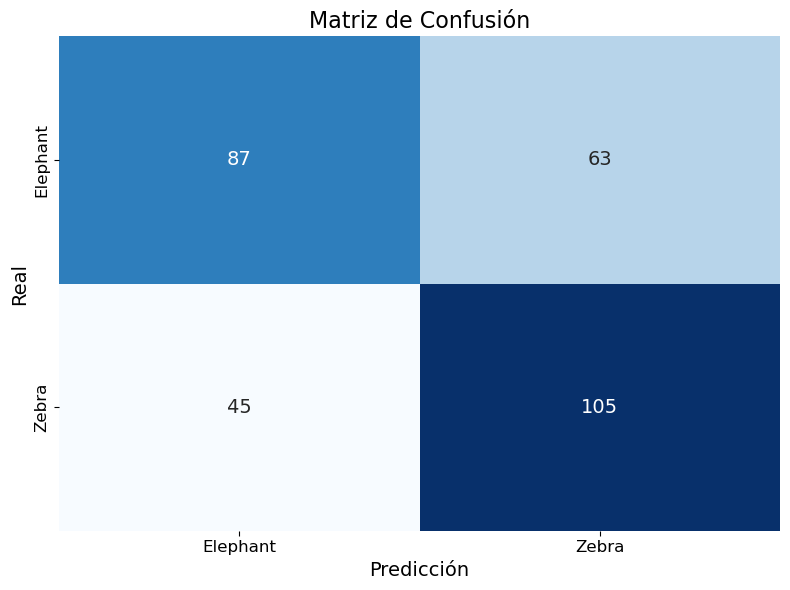

In [150]:
flex_confusion_matrix(cm=cm_val, nombre_archivo="lbpu_val_cm", labels=["Elephant", "Zebra"])

In [151]:
# metricas
print(f"Accuracy: {val_score:.3f}")
print(f"Precision: {precision(cm_val):.3f}")
print(f"Recall: {recall(cm_val):.3f}")
print(f"Specificity: {specificity(cm_val):.3f}")
print(f"F1: {f1(cm_val):.3f}")

Accuracy: 0.640
Precision: 0.625
Recall: 0.700
Specificity: 0.580
F1: 0.660


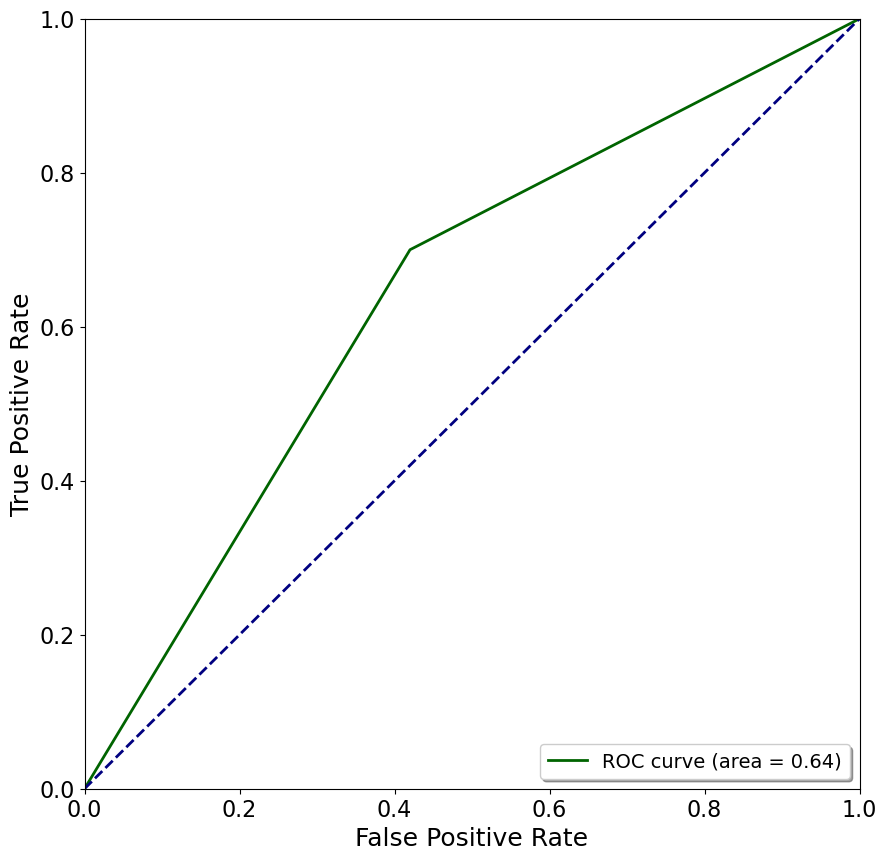

In [152]:
curvaROC(y_val, valid_classes, "lbpu_val_roc")

# Tercera clase: BUFALO

In [155]:
PATH_THIRD_TRAIN = "dataset2/Train/Buffalo/"
PATH_THIRD_TEST = "dataset2/Test/Buffalo/"
PATH_THIRD_VALID = "dataset2/Valid/Buffalo/"

In [156]:
reescalar_imagenes('dataset/Train/Buffalo', 'dataset2/Train/Buffalo',"Buffalo")
reescalar_imagenes('dataset/Test/Buffalo', 'dataset2/Test/Buffalo',"Buffalo")
reescalar_imagenes('dataset/Valid/Buffalo', 'dataset2/Valid/Buffalo',"Buffalo")

¡Hecho! Se han transformado 750 imágenes.
¡Hecho! Se han transformado 100 imágenes.
¡Hecho! Se han transformado 150 imágenes.


In [157]:
# Cargamos los datos con descriptor HOG
training_data_3_HOG, training_classes_3_HOG = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, PATH_THIRD_TRAIN, ALG="HOG")
test_data_3_HOG, test_classes_3_HOG = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, PATH_THIRD_TEST, ALG="HOG")
valid_data_3_HOG, valid_classes_3_HOG = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, PATH_THIRD_VALID, ALG="HOG")
data_3_HOG = np.concatenate((training_data_3_HOG, test_data_3_HOG), axis=0)
classes_3_HOG = np.concatenate((training_classes_3_HOG, test_classes_3_HOG), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 750 imágenes de la tercera clase.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 100 imágenes de la tercera clase.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.
Leídas 150 imágenes de la tercera clase.


In [158]:
# Cargamos los datos con descriptor LBP
training_data_3_LBP, training_classes_3_LBP = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, PATH_THIRD_TRAIN, ALG="LBP")
test_data_3_LBP, test_classes_3_LBP = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, PATH_THIRD_TEST, ALG="LBP")
valid_data_3_LBP, valid_classes_3_LBP = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, PATH_THIRD_VALID, ALG="LBP")
data_3_LBP = np.concatenate((training_data_3_LBP, test_data_3_LBP), axis=0)
classes_3_LBP = np.concatenate((training_classes_3_LBP, test_classes_3_LBP), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 750 imágenes de la tercera clase.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 100 imágenes de la tercera clase.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.
Leídas 150 imágenes de la tercera clase.


In [159]:
# Cargamos los datos con descriptor LBPU
training_data_3_LBPU, training_classes_3_LBPU = load_training_data(PATH_POSITIVE_TRAIN, PATH_NEGATIVE_TRAIN, PATH_THIRD_TRAIN, ALG="LBPU")
test_data_3_LBPU, test_classes_3_LBPU = load_training_data(PATH_POSITIVE_TEST, PATH_NEGATIVE_TEST, PATH_THIRD_TEST, ALG="LBPU")
valid_data_3_LBPU, valid_classes_3_LBPU = load_training_data(PATH_POSITIVE_VALID, PATH_NEGATIVE_VALID, PATH_THIRD_VALID, ALG="LBPU")
data_3_LBPU = np.concatenate((training_data_3_LBPU, test_data_3_LBPU), axis=0)
classes_3_LBPU = np.concatenate((training_classes_3_LBPU, test_classes_3_LBPU), axis=None)

Leídas 750 imágenes positivas.
Leídas 750 imágenes negativas.
Leídas 750 imágenes de la tercera clase.
Leídas 100 imágenes positivas.
Leídas 100 imágenes negativas.
Leídas 100 imágenes de la tercera clase.
Leídas 150 imágenes positivas.
Leídas 150 imágenes negativas.
Leídas 150 imágenes de la tercera clase.


In [160]:
# HOG
SVM_HOG = SVC(kernel="linear", C=0.01, cache_size=1500, decision_function_shape="ovr")
SVM_HOG.fit(data_3_HOG, classes_3_HOG)
val_hog_y = SVM_HOG.predict(valid_data_3_HOG)
cm_val_hog = confusion_matrix(valid_classes_3_HOG, val_hog_y)

# LBP
SVM_LBP = SVC(kernel="rbf", C=1, gamma='scale', cache_size=1500, decision_function_shape="ovr")
SVM_LBP.fit(data_3_LBP, classes_3_LBP)
val_lbp_y = SVM_LBP.predict(valid_data_3_LBP)
cm_val_lbp = confusion_matrix(valid_classes_3_LBP, val_lbp_y)

# LBPU
SVM_LBPU = SVC(kernel="rbf", C=1, gamma='scale', cache_size=1500, decision_function_shape="ovr")
SVM_LBPU.fit(data_3_LBPU, classes_3_LBPU)
val_lbpu_y = SVM_LBPU.predict(valid_data_3_LBPU)
cm_val_lbpu = confusion_matrix(valid_classes_3_LBPU, val_lbpu_y)

In [161]:
# classification report
print("HOG")
print(classification_report(valid_classes_3_HOG, val_hog_y))
print("LBP")
print(classification_report(valid_classes_3_LBP, val_lbp_y))
print("LBPU")
print(classification_report(valid_classes_3_LBPU, val_lbpu_y))

HOG
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       150
           1       0.67      0.67      0.67       150
           2       0.59      0.61      0.60       150

    accuracy                           0.66       450
   macro avg       0.67      0.66      0.67       450
weighted avg       0.67      0.66      0.67       450

LBP
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       150
           1       0.57      0.47      0.51       150
           2       0.54      0.73      0.62       150

    accuracy                           0.56       450
   macro avg       0.57      0.56      0.56       450
weighted avg       0.57      0.56      0.56       450

LBPU
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       150
           1       0.60      0.45      0.52       150
           2       0.52      0.70      0.59       150

    acc

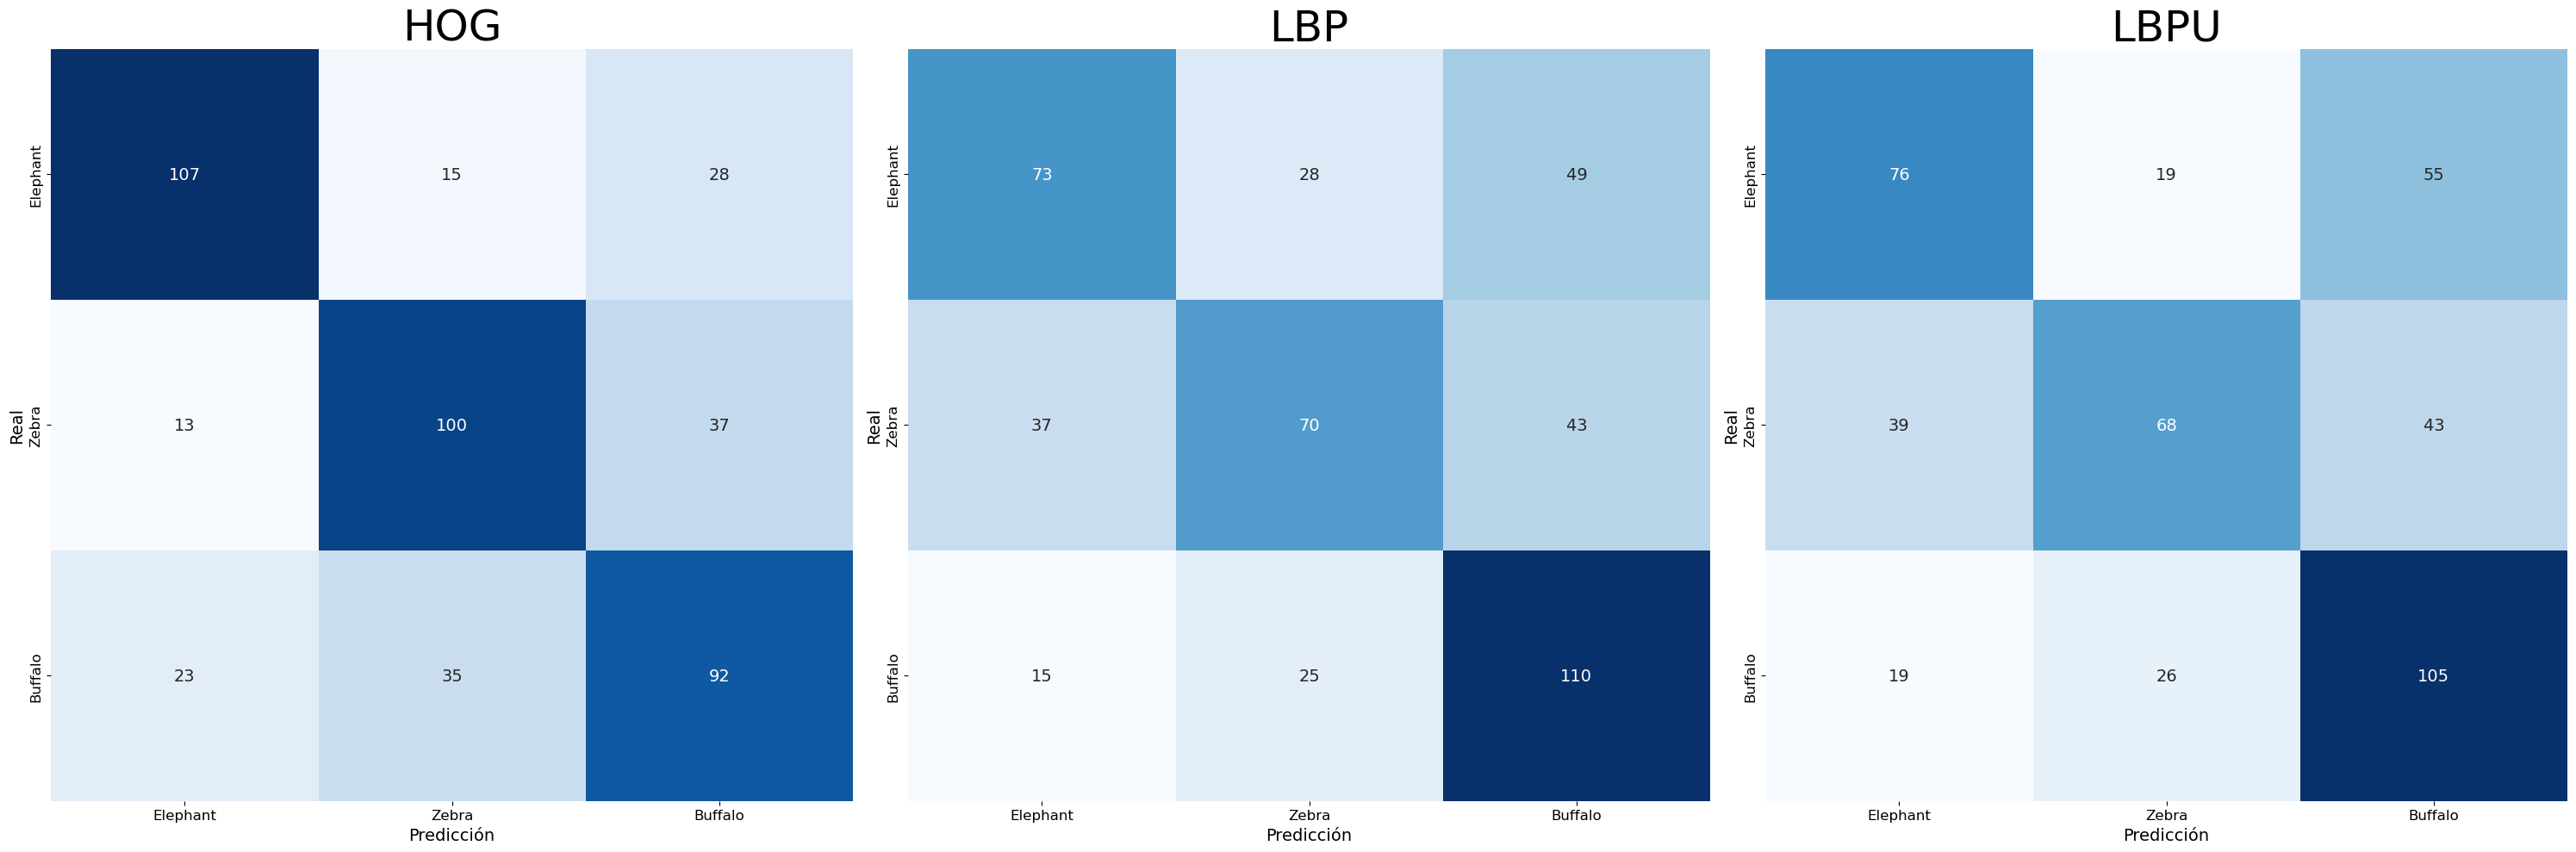

In [165]:
# Función ajustada para evitar interferencias
def flex_confusion_matrix_inline(cm, labels, tick_size=12, annot_size=14, cmap="Blues"):
    """
    Dibuja una matriz de confusión sin crear una nueva figura (para usar con subplots).
    """
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=labels, yticklabels=labels, 
                cbar=False, annot_kws={"size": annot_size})
    plt.xlabel("Predicción", fontsize=14)
    plt.ylabel("Real", fontsize=14)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)

# Graficar las tres matrices de confusión
plt.figure(figsize=(30, 10))

# HOG
plt.subplot(1, 3, 1)
flex_confusion_matrix_inline(cm=cm_val_hog, labels=["Elephant", "Zebra", "Buffalo"])
plt.title("HOG", fontsize=36)

# LBP
plt.subplot(1, 3, 2)
flex_confusion_matrix_inline(cm=cm_val_lbp, labels=["Elephant", "Zebra", "Buffalo"])
plt.title("LBP", fontsize=36)

# LBPU
plt.subplot(1, 3, 3)
flex_confusion_matrix_inline(cm=cm_val_lbpu, labels=["Elephant", "Zebra", "Buffalo"])
plt.title("LBPU", fontsize=36)

# Guardar la figura combinada
plt.tight_layout()  # Asegura que las subplots no se solapen
plt.savefig("imagenes_p1/val_3_cm.png", dpi=300)
plt.show()